In [1]:
import os
import sys
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
import keras.layers as klayers
import keras.models as kmodel
import keras.callbacks as kcallbacks
import keras.optimizers as koptimizers

Using TensorFlow backend.


In [2]:
df = pd.read_csv('datasets/PRSA_data_2010.1.1-2014.12.31.csv')
df.head(5)

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [3]:
df['datetime'] = df[['year', 'month', 'day', 'hour']].apply(lambda row: datetime.datetime( 
    year=row['year'], month=row['month'], day=row['day'], hour=row['hour']), axis=1)
df.sort_values('datetime', ascending=True, inplace=True)

In [4]:
scaler = MinMaxScaler(feature_range=(0, 1))
df['scaled_PRES'] = scaler.fit_transform(np.array(df['PRES']).reshape(-1, 1))

In [5]:
split_date = datetime.datetime(year=2014, month=1, day=1, hour=0)
df_train = df.loc[df['datetime']<split_date]
df_val = df.loc[df['datetime']>=split_date]
print('Shape of train:', df_train.shape)
print('Shape of test:', df_val.shape)

Shape of train: (35064, 15)
Shape of test: (8760, 15)


In [17]:
df_val.reset_index(drop=True, inplace=True)

In [19]:
def makeXy(ts, nb_timesteps):
    """
    Input:
        s: original time series
        nb_timesteps: number of time steps in the regressors
    Output:
        X: 2-D array of regressors
        y: 1-D array of target
    """
    X = []
    y = []
    for i in range(nb_timesteps, ts.shape[0]):
        piece = ts.loc[i-nb_timesteps:i-1]
        X.append(list(piece))
        y.append(ts.loc[i])
    X, y = np.array(X), np.array(y)
    return X, y

In [20]:
X_train, y_train = makeXy(df_train['scaled_PRES'], 7)
print('Shape of train arrays:', X_train.shape, y_train.shape)
X_val, y_val = makeXy(df_val['scaled_PRES'], 7)
print('Shape of validation arrays:', X_val.shape, y_val.shape)

Shape of train arrays: (35057, 7) (35057,)
Shape of validation arrays: (8753, 7) (8753,)


In [21]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
print('Shape of 3D arrays:', X_train.shape, X_val.shape)

Shape of 3D arrays: (35057, 7, 1) (8753, 7, 1)


In [22]:
input_layer = klayers.Input(shape=(7,1), dtype='float32')
lstm_layer = klayers.recurrent.LSTM(64, input_shape=(7,1),
return_sequences=False)(input_layer)

In [23]:
dropout_layer = klayers.Dropout(0.2)(lstm_layer)
output_layer = klayers.Dense(1, activation='linear')(dropout_layer)

In [24]:
ts_model = kmodel.Model(inputs=input_layer, outputs=output_layer)
ts_model.compile(loss='mean_squared_error', optimizer='adam')

In [27]:
save_weights_at = os.path.join('keras_models', 'PRSA_data_Air_Pressure_LSTM_weights.{epoch:02d}-{val_loss:.4f}.hdf5')
save_best = kcallbacks.ModelCheckpoint(save_weights_at, monitor='val_loss', verbose=0, 
                            save_best_only=True, save_weights_only=False, mode='min', period=1)
ts_model.fit(x=X_train, y=y_train, batch_size=16, epochs=20, verbose=1, 
             callbacks=[save_best], validation_data=(X_val, y_val), shuffle=True)

Train on 35057 samples, validate on 8753 samples
Epoch 1/20
35057/35057 [==============================] - 20s 559us/step - loss: 2.9781e-04 - val_loss: 1.4648e-04
Epoch 2/20
35057/35057 [==============================] - 19s 547us/step - loss: 2.9667e-04 - val_loss: 1.5037e-04
Epoch 3/20
35057/35057 [==============================] - 19s 543us/step - loss: 2.9815e-04 - val_loss: 1.3846e-04
Epoch 4/20
35057/35057 [==============================] - 19s 537us/step - loss: 2.9427e-04 - val_loss: 1.3213e-04
Epoch 5/20
35057/35057 [==============================] - 19s 551us/step - loss: 2.9092e-04 - val_loss: 1.3224e-04
Epoch 6/20
35057/35057 [==============================] - 19s 544us/step - loss: 2.9465e-04 - val_loss: 1.4381e-04
Epoch 7/20
35057/35057 [==============================] - 19s 547us/step - loss: 2.9828e-04 - val_loss: 1.5716e-04
Epoch 8/20
35057/35057 [==============================] - 19s 538us/step - loss: 2.9040e-04 - val_loss: 1.4012e-04
Epoch 9/20
35057/35057 [=======

In [28]:
best_model = kmodel.load_model(os.path.join('keras_models','PRSA_data_Air_Pressure_LSTM_weights.10-0.0001.hdf5'))
preds = best_model.predict(X_val)
pred_PRES = scaler.inverse_transform(preds)
pred_PRES = np.squeeze(pred_PRES)

Text(0.5, 0, 'Index')

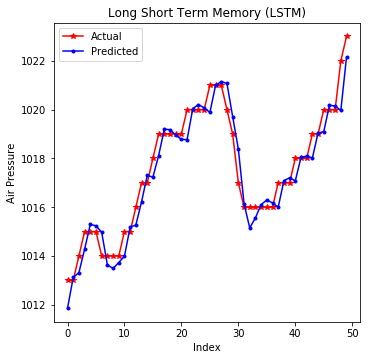

In [30]:
plt.figure(figsize=(5.5, 5.5))
plt.plot(range(50), df_val['PRES'].iloc[7:57], linestyle='-', marker='*', color='r')
plt.plot(range(50), pred_PRES[:50], linestyle='-', marker='.', color='b')
plt.legend(['Actual','Predicted'], loc=2)
plt.title('Long Short Term Memory (LSTM)')
plt.ylabel('Air Pressure')
plt.xlabel('Index')

In [32]:
input_layer = klayers.Input(shape=(7,1), dtype='float32')
gru_layer1 = klayers.GRU(64, input_shape=(7,1), return_sequences=True)(input_layer)
gru_layer2 = klayers.GRU(32, input_shape=(7,64), return_sequences=False)(gru_layer1)
dropout_layer = klayers.Dropout(0.2)(gru_layer2)
output_layer = klayers.Dense(1, activation='linear')(dropout_layer)

In [33]:
ts_model = kmodel.Model(inputs=input_layer, outputs=output_layer)
ts_model.compile(loss='mse', optimizer='adam')
ts_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 7, 1)              0         
_________________________________________________________________
gru_3 (GRU)                  (None, 7, 64)             12672     
_________________________________________________________________
gru_4 (GRU)                  (None, 32)                9312      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 22,017
Trainable params: 22,017
Non-trainable params: 0
_________________________________________________________________


In [34]:
save_weights_at = os.path.join('keras_models', 'PRSA_data_Air_Pressure_GRU_weights.{epoch:02d}-{val_loss:.4f}.hdf5')
save_best = kcallbacks.ModelCheckpoint(save_weights_at, monitor='val_loss', verbose=0,
                            save_best_only=True, save_weights_only=False, mode='min',
                            period=1)
ts_model.fit(x=X_train, y=y_train, batch_size=16, epochs=20,
             verbose=1, callbacks=[save_best], validation_data=(X_val, y_val),
             shuffle=True)

Train on 35057 samples, validate on 8753 samples
Epoch 1/20
35057/35057 [==============================] - 31s 884us/step - loss: 0.0023 - val_loss: 2.3995e-04
Epoch 2/20
35057/35057 [==============================] - 27s 784us/step - loss: 6.8105e-04 - val_loss: 2.2001e-04
Epoch 3/20
35057/35057 [==============================] - 29s 827us/step - loss: 4.8957e-04 - val_loss: 1.3633e-04
Epoch 4/20
35057/35057 [==============================] - 26s 751us/step - loss: 4.7885e-04 - val_loss: 2.1575e-04
Epoch 5/20
35057/35057 [==============================] - 28s 810us/step - loss: 4.6463e-04 - val_loss: 1.6867e-04
Epoch 6/20
35057/35057 [==============================] - 27s 774us/step - loss: 4.6220e-04 - val_loss: 1.3961e-04
Epoch 7/20
35057/35057 [==============================] - 28s 791us/step - loss: 4.6674e-04 - val_loss: 1.5794e-04
Epoch 8/20
35057/35057 [==============================] - 25s 705us/step - loss: 4.6364e-04 - val_loss: 1.7438e-04
Epoch 9/20
35057/35057 [===========

In [35]:
best_model = kmodel.load_model(os.path.join('keras_models','PRSA_data_Air_Pressure_GRU_weights.03-0.0001.hdf5'))
preds = best_model.predict(X_val)
pred_PRES = scaler.inverse_transform(preds)
pred_PRES = np.squeeze(pred_PRES)

Text(0.5, 0, 'Index')

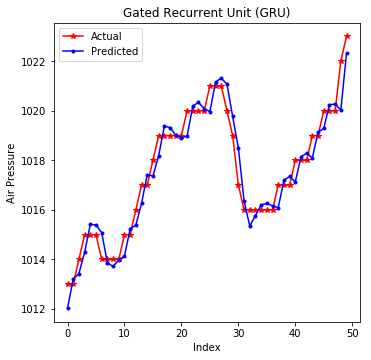

In [36]:
plt.figure(figsize=(5.5, 5.5))
plt.plot(range(50), df_val['PRES'].iloc[7:57], linestyle='-', marker='*', color='r')
plt.plot(range(50), pred_PRES[:50], linestyle='-', marker='.', color='b')
plt.legend(['Actual','Predicted'], loc=2)
plt.title('Gated Recurrent Unit (GRU)')
plt.ylabel('Air Pressure')
plt.xlabel('Index')